In [49]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

# Data preprocessing and feature extraction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import exposure
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine learning models
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import skfuzzy as fuzz

# evaluation metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, classification_report

In [6]:
# Set data paths
DATA_DIR = "./data"
SOURCE_FILE = "fer2013.csv"

# Load data from local path
df = pd.read_csv(SOURCE_FILE)

# print basic info
print("Loaded FER-2013 with shape:", df.shape)
print(df["Usage"].value_counts())
df.head()

# Ensure training directory exists
os.makedirs((DATA_DIR), exist_ok=True)

# We use for training and validation the "Training" and "PublicTest"
train_df = df[df['Usage']== 'Training'].copy()
vali_df = df[df['Usage'] == 'PublicTest'].copy()
test_df = df[df['Usage'] == 'PrivateTest'].copy() 

# Storing train and test data frames
train_df.to_csv("./data/fer2013_train.csv", encoding='utf-8', index=False)
vali_df.to_csv("./data/fer2013_validation.csv", encoding='utf-8', index=False)
test_df.to_csv("./data/fer2013_test.csv", encoding='utf-8', index=False)


Loaded FER-2013 with shape: (35887, 3)
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


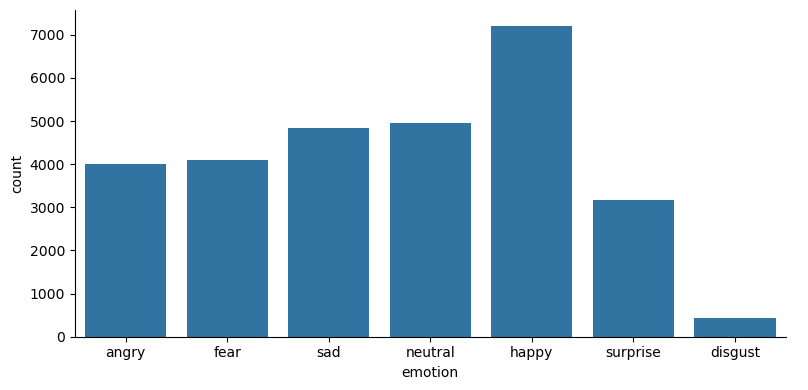

In [7]:
# Define label mapping
label_map = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}
# Map integer labels to emotion names
sns.catplot(data=train_df.replace({'emotion': label_map}), kind='count', x='emotion', height=4, aspect=2)

#sns.countplot(x ='emotion', data = trai_df)
plt.show()

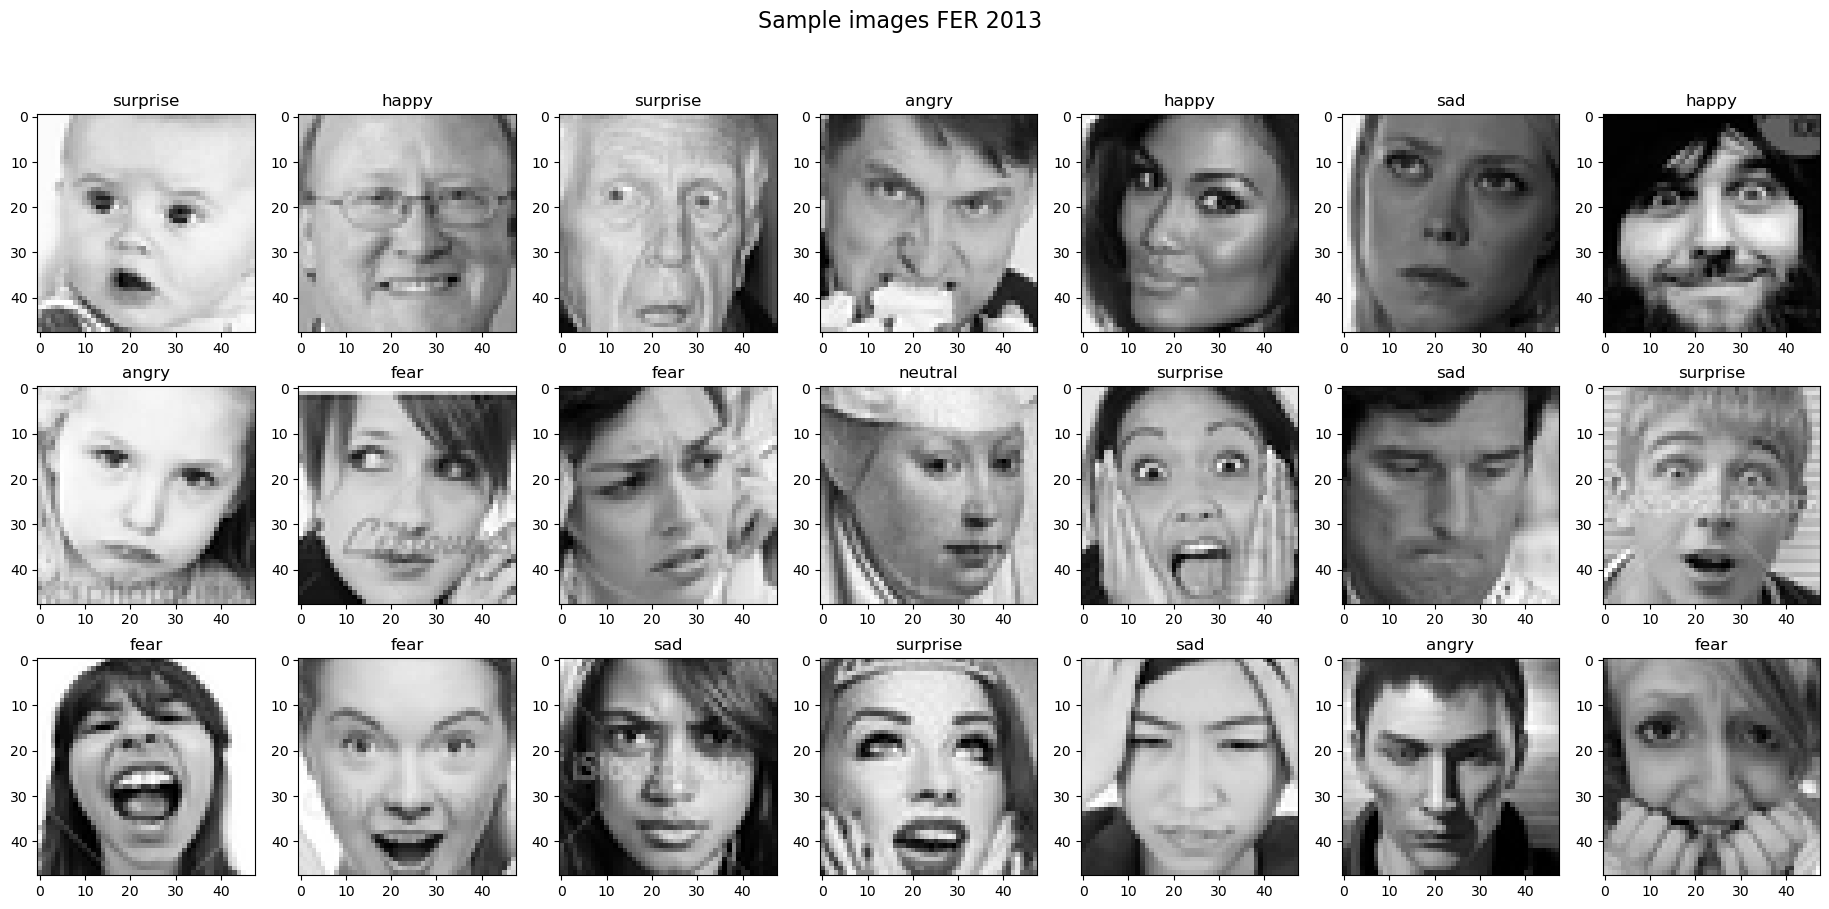

In [8]:
# Now making some plots
random_rows = df.sample(n=21, random_state=43)
imgs = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in random_rows['pixels']]
lbl =  random_rows['emotion'].values

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(23, 10))
fig.suptitle('Sample images FER 2013', fontsize=16)

# Loop through each subplot and customize
for i in range(7):
    for j in range(3):
        ax = axes[j, i]
        ax.imshow(imgs[j*7+i], cmap="gray") 
        ax.set_title('%s'%(label_map[lbl[j*7+i]]))
        #ax.grid(True)
plt.show()

In [9]:
# Create function for converting pixels string to 48x48 numpy array
def pixels_to_array(pixels_str):
   """
    Convert pixel string into a 48x48 NumPy array.
    Input:
    - pixels_str = string of 2304 grayscale pixel values (e.g., "70 80 82 ...")
    Output:
    - NumPy array of shape (48, 48) with dtype uint8 representing the image
    """
   return np.fromstring(pixels_str, sep=" ", dtype=np.uint8).reshape(48, 48)

In [10]:
def load_split(path):
    """Load a pre-split FER-2013 CSV file and return normalized image and label arrays.
    Input:
    - path = path to CSV file (e.g., './data/fer2013_train.csv')
    Output:
    - X = NumPy array of shape (N, 48, 48) with normalized pixel values in [0, 1]
    - y = NumPy array of shape (N,) with integer emotion labels (0–6)
    """
    # read CSV file and convert pixels to arrays and labels to integers
    df = pd.read_csv(path)
    X = np.stack(df["pixels"].apply(pixels_to_array))
    y = df["emotion"].to_numpy(dtype=np.int64)

    # Normalize pixel values to [0, 1]
    X = X.astype(np.float32) / 255.0 
    print(f"{path}: X={X.shape}, y={y.shape}")
    return X, y


# Load each split
X_train, y_train = load_split("./data/fer2013_train.csv")
X_val, y_val     = load_split("./data/fer2013_validation.csv")
X_test, y_test   = load_split("./data/fer2013_test.csv")

./data/fer2013_train.csv: X=(28709, 48, 48), y=(28709,)
./data/fer2013_validation.csv: X=(3589, 48, 48), y=(3589,)
./data/fer2013_test.csv: X=(3589, 48, 48), y=(3589,)


In [11]:
# DEBUG, i think all model support "weighted" as class weight option
# So this might be redundant

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {label_map[c]: w for c, w in zip(classes, class_weights)}
print("Class weights (use for sklearn models):")
print(class_weights_dict)

Class weights (use for sklearn models):
{'angry': np.float64(1.0266046844269623), 'disgust': np.float64(9.406618610747051), 'fear': np.float64(1.0010460615781582), 'happy': np.float64(0.5684387684387684), 'sad': np.float64(0.8491274770777877), 'surprise': np.float64(1.293372978330405), 'neutral': np.float64(0.8260394187886635)}


In [14]:
def extract_features(X, params=None):
    """
    Extract multiple types of features (raw, HOG, LBP) from grayscale images.

    Input:
    - X: NumPy array of shape (N, 48, 48)
    - params: dict containing 'hog' and 'lbp' parameter sets

    Output:
    - X_raw: flattened & normalized raw pixel features (N, 2304)
    - X_hog: HOG feature vectors (N, ?)
    - X_lbp: normalized LBP histograms (N, bins)
    """
    # --- Raw pixel features ---
    X_raw = X.reshape(len(X), -1).astype(np.float32) / 255.0

    # --- HOG features ---
    hog_params = params["hog"]
    X_hog = np.asarray([hog(img, **hog_params) for img in X], dtype=np.float32)

    # --- LBP features ---
    lbp_params = params["lbp"]
    P, R, method = lbp_params["P"], lbp_params["R"], lbp_params["method"]
    n_bins = P + 2 if method == "uniform" else int(X.max()) + 1
    X_lbp = []
    for img in X:
        lbp = local_binary_pattern(img, P=P, R=R, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype(np.float32)
        hist /= (hist.sum() + 1e-8)
        X_lbp.append(hist)
    X_lbp = np.asarray(X_lbp, dtype=np.float32)

    print(f"Extracted: RAW={X_raw.shape}, HOG={X_hog.shape}, LBP={X_lbp.shape}")
    return X_raw, X_hog, X_lbp

Extracted: RAW=(28709, 2304), HOG=(28709, 900), LBP=(28709, 10)
Extracted: RAW=(3589, 2304), HOG=(3589, 900), LBP=(3589, 10)
Extracted: RAW=(3589, 2304), HOG=(3589, 900), LBP=(3589, 10)


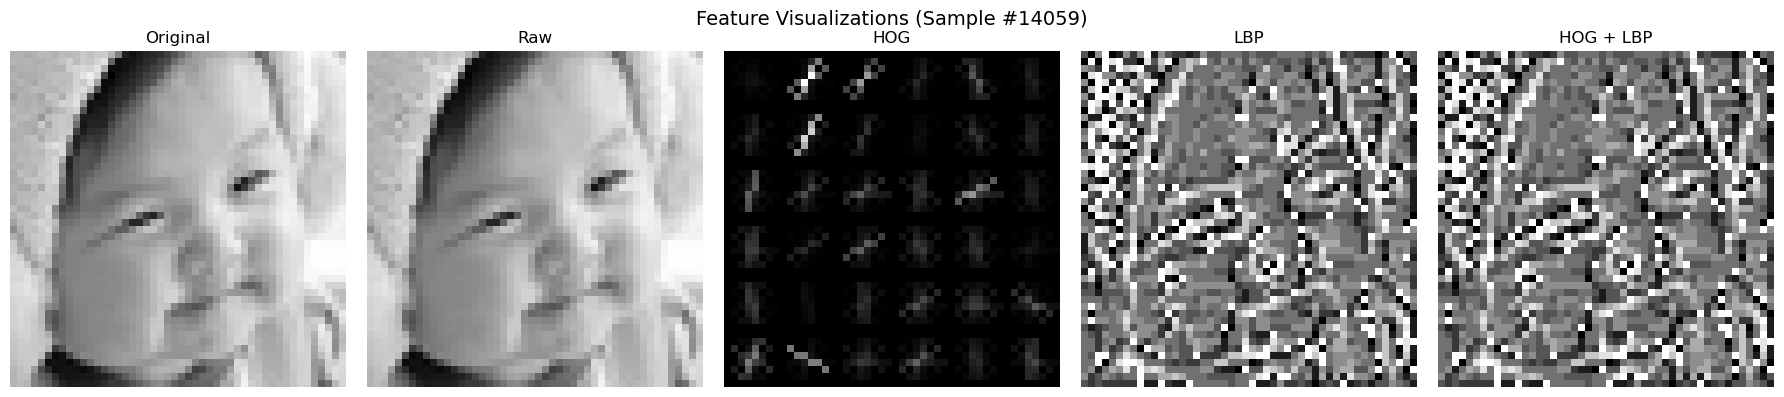

In [ ]:
FEATURE_PARAMS = {
    "hog": {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2),
        "block_norm": "L2-Hys", "transform_sqrt": True, "feature_vector": True},
    "lbp": {"P": 8, "R": 1.0, "method": "uniform"}}


# Build features for all splits
X_train_raw, X_train_hog, X_train_lbp = extract_features(X_train, FEATURE_PARAMS)
X_val_raw,   X_val_hog,   X_val_lbp  = extract_features(X_val, FEATURE_PARAMS)
X_test_raw,  X_test_hog,  X_test_lbp = extract_features(X_test, FEATURE_PARAMS)

# Pick one random image index
idx = np.random.randint(len(X_train))
img = X_train[idx].reshape(48, 48)

# HOG visualization
hog_params = FEATURE_PARAMS["hog"].copy()
hog_params["feature_vector"] = False
_, hog_img = hog(img, visualize=True, **hog_params)
hog_img = exposure.rescale_intensity(hog_img, in_range=(0, 10))

# LBP visualization
lbp_params = FEATURE_PARAMS["lbp"]
lbp_img = local_binary_pattern(img, **lbp_params)

# Combined HOG + LBP
combined = np.maximum(
    exposure.rescale_intensity(hog_img, in_range=(0, 10)),
    exposure.rescale_intensity(lbp_img / lbp_img.max(), in_range=(0, 1))
)

# Plot all variants
images = [img, img, hog_img, lbp_img, combined]
titles = ["Original", "Raw", "HOG", "LBP", "HOG + LBP"]

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for ax, im, title in zip(axes, images, titles):
    ax.imshow(im, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

fig.suptitle(f"Feature Visualizations (Sample #{idx})", fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
# Train scalers on training data
scaler_raw = StandardScaler().fit(X_train_raw)
scaler_hog = StandardScaler().fit(X_train_hog)
scaler_lbp = StandardScaler().fit(X_train_lbp)

# Apply scalers to all features
X_train_raw = scaler_raw.transform(X_train_raw)
X_val_raw   = scaler_raw.transform(X_val_raw)
X_test_raw  = scaler_raw.transform(X_test_raw)

X_train_hog = scaler_hog.transform(X_train_hog)
X_val_hog   = scaler_hog.transform(X_val_hog)
X_test_hog  = scaler_hog.transform(X_test_hog)

X_train_lbp = scaler_lbp.transform(X_train_lbp)
X_val_lbp   = scaler_lbp.transform(X_val_lbp)
X_test_lbp  = scaler_lbp.transform(X_test_lbp)


In [17]:
# PCA (fit ONLY on train, apply to all)

# Amount of variance to keep, 0.95 = 95% variance explained
PCA_N_COMPONENTS = 0.95

# PCA for RAW
pca_raw = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
X_train_raw = pca_raw.fit_transform(X_train_raw)
X_val_raw   = pca_raw.transform(X_val_raw)
X_test_raw  = pca_raw.transform(X_test_raw)
print(f"RAW → {pca_raw.n_components_} components "
      f"({pca_raw.explained_variance_ratio_.sum():.2%} variance)")

# PCA for HOG
pca_hog = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
X_train_hog = pca_hog.fit_transform(X_train_hog)
X_val_hog   = pca_hog.transform(X_val_hog)
X_test_hog  = pca_hog.transform(X_test_hog)
print(f"HOG → {pca_hog.n_components_} components "
      f"({pca_hog.explained_variance_ratio_.sum():.2%} variance)")

# PCA for LBP
pca_lbp = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
X_train_lbp = pca_lbp.fit_transform(X_train_lbp)
X_val_lbp   = pca_lbp.transform(X_val_lbp)
X_test_lbp  = pca_lbp.transform(X_test_lbp)
print(f"LBP → {pca_lbp.n_components_} components "
      f"({pca_lbp.explained_variance_ratio_.sum():.2%} variance)")

RAW → 269 components (95.01% variance)
HOG → 277 components (95.03% variance)
LBP → 7 components (97.03% variance)


In [ ]:
# Now that we have all features, and scaled them appropriately,
# we can combine them into a single feature set for each split
X_train_all = np.hstack([X_train_raw, X_train_hog, X_train_lbp])
X_val_all   = np.hstack([X_val_raw, X_val_hog, X_val_lbp])
X_test_all  = np.hstack([X_test_raw, X_test_hog, X_test_lbp])

print("Combined feature shapes:")
print("  Train:", X_train_all.shape)
print("  Val:", X_val_all.shape)
print("  Test:", X_test_all.shape)

# Create feature sets to check in gridsearch
feature_sets = {
    "raw": (X_train_raw, X_val_raw),
    "hog": (X_train_hog, X_val_hog),
    "lbp": (X_train_lbp, X_val_lbp),
    "hog+lbp": (
        np.hstack([X_train_hog, X_train_lbp]),
        np.hstack([X_val_hog, X_val_lbp])),
    "all": (X_train_all, X_val_all)
}

Combined feature shapes:
  Train: (28709, 553)
  Val: (3589, 553)
  Test: (3589, 553)


In [ ]:
def print_scores(name, y_true, y_pred, labels=None):
    """ 
    Evaluate and visualize model performance.

    Input:
    - name (str): Name of the model (for printing)
    - y_true (array-like): True class labels
    - y_pred (array-like): Predicted class labels
    - labels (list, optional): Class label names for confusion matrix

    Output:
    - Prints Accuracy, Cohen’s Kappa, and F1-score
    - Displays confusion matrix heatmap
    """
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Print numeric results
    print(f"Total {name} evaluation:")
    print(f"Accuracy:       {acc:.3f}")
    print(f"Cohen’s Kappa:  {kappa:.3f}")
    print(f"Weighted F1:    {f1:.3f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    

In [55]:
# For quick grid search, we can use a smaller subset of the training data. 
# Since SVM scales O(n^2) low n reduces computation time significantly.
# We use stratified sampling to keep class distribution similar.
def make_subset(X, y, fraction=0.1, seed=42):
    """
    Create a smaller, stratified subset of data for faster grid searches.

    Input:
    - X: np.ndarray, full training feature matrix
    - y: np.ndarray, corresponding labels
    - fraction: fraction of samples to keep (default 0.1 = 10%)
    - seed: random_state for reproducibility

    Output:
    - X_sub, y_sub: stratified subset of the data
    """
    X_sub, _, y_sub, _ = train_test_split(
        X, y,
        train_size=fraction,
        stratify=y,
        random_state=seed
    )
    return X_sub, y_sub

# Models

In [ ]:

# Define SVM parameter grid
param_grid = {
    "kernel": ["linear", "rbf"],
    "C": [1, 5, 10],
    "gamma": ["scale", "auto"]
}

# Perform gridsearch for each feature set
results = []

print("\nStarting grid search over feature sets, expected duration: 3 minutes")
for name, (Xtr, Xval) in feature_sets.items():
    print(f"\nTesting feature set: {name}")

    # Create smaller subset for faster search
    X_sub, y_sub = make_subset(Xtr, y_train, fraction=0.1)

    # Run gridsearch
    grid = GridSearchCV(
        SVC(class_weight="balanced"),
        param_grid=param_grid,
        cv=2,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_sub, y_sub)
    best_model = grid.best_estimator_

    # Evaluate on validation set
    y_pred = best_model.predict(Xval)
    f1 = f1_score(y_val, y_pred, average="weighted")
    acc = accuracy_score(y_val, y_pred)

    print(f"{name}: F1={f1:.3f}, Acc={acc:.3f}, Params={grid.best_params_}")
    results.append((name, f1, acc, grid.best_params_))

# Report best feature set
bestsvm = max(results, key=lambda r: r[1])
print("\n Best Feature Set:")
print(f"Feature type: {bestsvm[0]}")
print(f"F1={bestsvm[1]:.3f}, Acc={best[2]:.3f}")
print(f"Best Params: {bestsvm[3]}")


🔍 Testing feature set: raw
✅ raw: F1=0.361, Acc=0.366, Params={'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

🔍 Testing feature set: hog
✅ hog: F1=0.427, Acc=0.434, Params={'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

🔍 Testing feature set: lbp
✅ lbp: F1=0.187, Acc=0.190, Params={'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

🔍 Testing feature set: pca
✅ pca: F1=0.438, Acc=0.445, Params={'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

🔍 Testing feature set: hog+lbp
✅ hog+lbp: F1=0.426, Acc=0.433, Params={'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

🏆 Best Feature Set:
Feature type: pca
F1=0.438, Acc=0.445
Best Params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Unpack best results
best_name, best_f1, best_acc, best_params = bestsvm

print(f"\n Retraining final SVM model using best feature set: {best_name}, this can take 10 min...")

# Select correct features
Xtr_full, Xte_full = feature_sets[best_name]

# Define the final SVM model with your preferred structure
svm_final = SVC(
    **best_params,
    class_weight="balanced",
    random_state=42
)

# Train on full training data
svm_final.fit(Xtr_full, y_train)

# Evaluate on test data
y_pred_test_svm = svm_final.predict(Xte_full)
print_scores("SVM Final", y_test, y_pred_test_svm, labels=[label_map[c] for c in classes])


Training final SVM on full training data...
Validation accuracy: 0.5625522429646141
              precision    recall  f1-score   support

           0      0.419     0.463     0.439       467
           1      0.968     0.536     0.690        56
           2      0.451     0.413     0.431       496
           3      0.710     0.743     0.726       895
           4      0.463     0.444     0.453       653
           5      0.760     0.718     0.739       415
           6      0.499     0.519     0.509       607

    accuracy                          0.563      3589
   macro avg      0.610     0.548     0.570      3589
weighted avg      0.565     0.563     0.562      3589



In [ ]:
# Define MLP parameter grid
param_grid = {
    "hidden_layer_sizes": [(256, 128), (512, 256)],
    "activation": ["relu"],
    "alpha": [0.0001, 0.001],
    "learning_rate_init": [0.001, 0.0005],
    "solver": ["adam"],
    "max_iter": [300],
    "random_state": [42]
}

# Perform gridsearch for each feature set
results = []

for name, (Xtr, Xval) in feature_sets.items():
    print(f"\nTesting feature set: {name}")

    # Create smaller subset for faster search
    X_sub, y_sub = make_subset(Xtr, y_train, fraction=0.05)

    # Run gridsearch
    grid = GridSearchCV(
        MLPClassifier(),
        param_grid=param_grid,
        cv=2,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_sub, y_sub)
    best_model = grid.best_estimator_

    # Evaluate on validation set
    y_pred = best_model.predict(Xval)
    f1 = f1_score(y_val, y_pred, average="weighted")
    acc = accuracy_score(y_val, y_pred)

    print(f"{name}: F1={f1:.3f}, Acc={acc:.3f}, Params={grid.best_params_}")
    results.append((name, f1, acc, grid.best_params_))

# Report best feature set
bestmlp = max(results, key=lambda r: r[1])
print("\nBest Feature Set:")
print(f"Feature type: {bestmlp[0]}")
print(f"F1={bestmlp[1]:.3f}, Acc={best[2]:.3f}")
print(f"Best Params: {bestmlp[3]}")



Testing feature set: raw


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


raw: F1=0.318, Acc=0.355, Params={'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (512, 256), 'learning_rate_init': 0.0005, 'max_iter': 200, 'random_state': 42, 'solver': 'adam'}

Testing feature set: hog
hog: F1=0.372, Acc=0.381, Params={'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (512, 256), 'learning_rate_init': 0.0005, 'max_iter': 200, 'random_state': 42, 'solver': 'adam'}

Testing feature set: lbp
lbp: F1=0.152, Acc=0.251, Params={'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001, 'max_iter': 200, 'random_state': 42, 'solver': 'adam'}

Testing feature set: pca
pca: F1=0.376, Acc=0.389, Params={'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (512, 256), 'learning_rate_init': 0.001, 'max_iter': 200, 'random_state': 42, 'solver': 'adam'}

Testing feature set: hog+lbp
hog+lbp: F1=0.363, Acc=0.370, Params={'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (256, 128), 'learning_rate_ini

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Retraining final MLP model using best feature set: pca
Total Best MLP evaluation:
Accuracy:       0.536
Cohen’s Kappa:  0.438
Weighted F1:    0.535

Classification Report:
              precision    recall  f1-score   support

       angry      0.399     0.418     0.408       467
     disgust      0.781     0.446     0.568        56
        fear      0.428     0.421     0.425       496
       happy      0.698     0.723     0.710       895
         sad      0.427     0.392     0.409       653
    surprise      0.705     0.701     0.703       415
     neutral      0.470     0.496     0.483       607

    accuracy                          0.536      3589
   macro avg      0.558     0.514     0.529      3589
weighted avg      0.536     0.536     0.535      3589



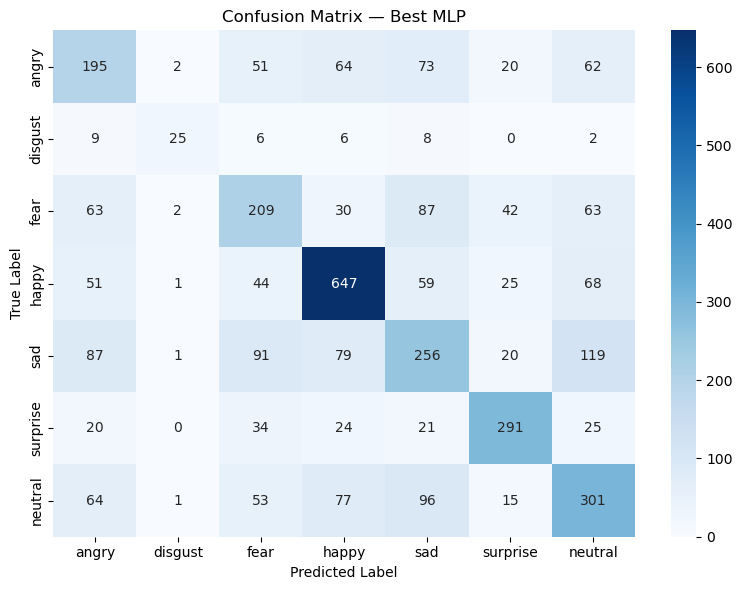

In [ ]:
# Unpack best MLP results
best_name, best_f1, best_acc, best_params = bestmlp

# Select corresponding full data
Xtr_full, Xte_full = feature_sets[best_name]

# Build final model with best parameters and train on full data
mlp_final = MLPClassifier(**best_params)
mlp_final.fit(Xtr_full, y_train)

# Evaluate on validation data
y_pred_test_mlp = mlp_final.predict(Xte_full) # predict on test set
print_scores("Best MLP", y_val, y_pred_test_mlp, labels=[label_map[c] for c in classes])

In [65]:
# Parameter grid to test with grid search
param_grid = {
    "n_estimators": [300, 500, 1000],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True],
    "random_state": [42]
}

# Perform gridsearch for each feature set
results = []

for name, (Xtr, Xval) in feature_sets.items():
    print(f"\nTesting feature set: {name}")

    # Create smaller subset for faster tuning
    X_sub, y_sub = make_subset(Xtr, y_train, fraction=0.05)

    # Run gridsearch
    grid = GridSearchCV(
        RandomForestClassifier(),
        param_grid=param_grid,
        cv=2,                       # use 2-fold cross-validation for speed
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_sub, y_sub)
    best_model = grid.best_estimator_

    # Evaluate on validation set
    y_pred = best_model.predict(Xval)
    f1 = f1_score(y_val, y_pred, average="weighted")
    acc = accuracy_score(y_val, y_pred)

    print(f"{name}: F1={f1:.3f}, Acc={acc:.3f}, Params={grid.best_params_}")
    results.append((name, f1, acc, grid.best_params_))

# Report best feature set
bestrf = max(results, key=lambda r: r[1])
print("\n Best Feature Set (Random Forest):")
print(f"Feature type: {bestrf[0]}")
print(f"F1={bestrf[1]:.3f}, Acc={bestrf[2]:.3f}")
print(f"Best Params: {bestrf[3]}")


Testing feature set: raw
raw: F1=0.295, Acc=0.348, Params={'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}

Testing feature set: hog
hog: F1=0.318, Acc=0.378, Params={'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000, 'random_state': 42}

Testing feature set: lbp
lbp: F1=0.205, Acc=0.253, Params={'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}

Testing feature set: pca
pca: F1=0.194, Acc=0.297, Params={'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 42}

Testing feature set: hog+lbp
hog+lbp: F1=0.315, Acc=0.375, Params={'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_sp

In [ ]:
# Unpack best RF results
best_name, best_f1, best_acc, best_params = bestrf

# Select feature set set with best performance
Xtr_full, Xte_full = feature_sets[best_name]

# Train final model with best parameters
rf_final = RandomForestClassifier(**best_params)
rf_final.fit(Xtr_full, y_train)

# Evaluate on test data
y_pred_test_rf = rf_final.predict(Xte_full)
print_scores("Random Forest Final", y_test, y_pred_test_rf, labels=[label_map[c] for c in classes])

Fuzzy Partition Coefficient (FPC): 0.143
Cluster → Emotion mapping:
  Cluster 0: happy
  Cluster 1: angry
  Cluster 2: angry
  Cluster 3: neutral
  Cluster 4: happy
  Cluster 5: happy
  Cluster 6: happy
Total Fuzzy Classifier evaluation:
Accuracy:       0.245
Cohen’s Kappa:  0.000
Weighted F1:    0.096

Classification Report:
              precision    recall  f1-score   support

       angry      0.000     0.000     0.000       491
     disgust      0.000     0.000     0.000        55
        fear      0.000     0.000     0.000       528
       happy      0.245     1.000     0.394       879
         sad      0.000     0.000     0.000       594
    surprise      0.000     0.000     0.000       416
     neutral      0.000     0.000     0.000       626

    accuracy                          0.245      3589
   macro avg      0.035     0.143     0.056      3589
weighted avg      0.060     0.245     0.096      3589



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


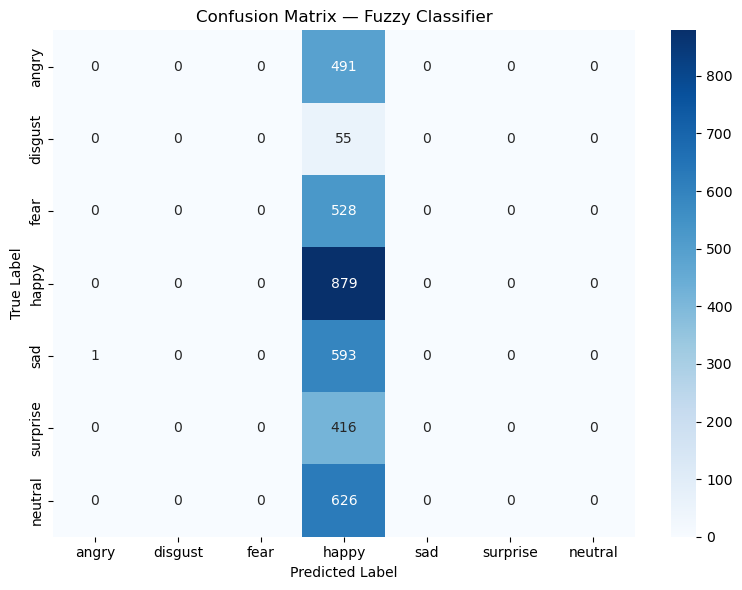

In [ ]:

X_train_T = X_train_all.T
X_test_T  = X_test_all.T

n_clusters = 7     # number of emotions
m = 2.0            # fuzziness coefficient

# Train fuzzy clusters on training data ---
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_train_T,
    c=n_clusters,
    m=m,
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42
)

print(f"Fuzzy Partition Coefficient (FPC): {fpc:.3f}")

# Assign each training sample to its strongest cluster ---
train_fcm_labels = np.argmax(u, axis=0)

# Map each cluster → most common true label in that cluster ---
labels_map_fcm = {}
for cluster_id in range(n_clusters):
    mask = (train_fcm_labels == cluster_id)
    if np.any(mask):
        labels_map_fcm[cluster_id] = pd.Series(y_train[mask]).mode()[0]

print("Cluster → Emotion mapping:")
for c, label in labels_map_fcm.items():
    print(f"  Cluster {c}: {label_map[label]}")

# Predict on test data using learned fuzzy centers ---
u_test, u0, d, jm, p, fpc_test = fuzz.cluster.cmeans_predict(
    X_test_T, cntr, m=m, error=0.005, maxiter=1000
)

# Hard cluster assignment for test samples
test_fcm_labels = np.argmax(u_test, axis=0)

# Convert cluster IDs → predicted emotion labels
y_test_pred_fuzzy = np.array([labels_map_fcm[c] for c in test_fcm_labels])

print_scores(
    "Fuzzy Classifier",
    y_test,
    y_test_pred_fuzzy,
    labels=list(label_map.values())
)

